## Conclusions and Visualizations

In this notebook we make conclusions from the numerical results of the experiments. We will also make some visualizations to help us understand the results better.

Contents:

- plot 1: x: min gain - max gain, y: fraction of pairs with gain smaller than x

- plot 2: average variance over all pairs over time

- average cycle length
 
- plot 3

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import scienceplots

plt.style.use(["science", "nature", "grid", "no-latex"])



In [3]:
def extend_to_length(arr, target_length=200):
    repeats = (target_length + len(arr) - 1) // len(arr)  # number of times to repeat
    extended = (arr * repeats)[:target_length]
    return extended

In [4]:
sym_file = "algorithm_results/Barcelonanew.out"
analytical_file = "barcelona.out"
with open(sym_file) as f:
    global data
    
    lines = f.readlines()

    # filter out pairs that were not simulated    
    data = [line for line in lines if not line.startswith("Not enough routes ")]

with open(analytical_file) as f:
    global analytical_data
    
    lines = f.readlines()

    # filter out pairs that were not simulated    
    analytical_data = [line for line in lines if not line.startswith("Not enough routes ")]

# create a pandas dataframe to store the data
data_dict = {}

# iterate over the lines - each od pair starts with a "Running simulation for" line
for i, line in enumerate(data):
    
    if not line.startswith("Running simulation for"):
        continue
        
    # get the origin and destination
    origin = line.split()[-2]
    destination = line.split()[-1]
    
    data_dict[(origin, destination)] = {}
    
    conv_line = data[i+1]
    data_dict[(origin, destination)]["convergence"] = -1
    if conv_line.startswith("Converged in"):
        # get the number of iterations
        data_dict[(origin, destination)]["convergence"] = int(conv_line.split()[-2])

    diff_line = data[i+2]
    data_dict[(origin, destination)]["difference"] = float(diff_line.split()[-2])
    data_dict[((origin, destination))]["UE_time"] = float(diff_line.split()[-1])
    
    mean_line = data[i+3]
    # array of mean values (floats)
    match = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", mean_line)

    
    if match:
        data_dict[(origin, destination)]["mean"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["mean"] = []
                
    variance_line = data[i+4]
    # array of variance values (floats)
    match = re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", variance_line)

    
    if match:
        data_dict[(origin, destination)]["variance"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["variance"] = []
        
    hist_line = data[i+5]
    # array of arrays of integers
    match = re.search(r"\[\[([0-9.,\s\[\]]+)\]\]", hist_line)
    
    if match:
        data_dict[(origin, destination)]["history"] = [list(map(int, x.split(",")) ) for x in match.group(1).split("], [")]
    else:
        data_dict[(origin, destination)]["history"] = []
    
    # get number of agents
    agents_line = data[i+6]
    data_dict[(origin, destination)]["agents"] = round(float(agents_line.split()[-1]))

    # get inequity
    inequity_line = data[i+7]
    
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", inequity_line)
    
    if match:
        data_dict[(origin, destination)]["inequity"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["inequity"] = []
        
    # get almost convergence
    almost_conv_line = data[i+8]

    # match that finds the array of integers, separated by commas and possibly negative
    match = re.search(r"\[([0-9,\s-]+)\]", almost_conv_line)
    
    if match:
        data_dict[(origin, destination)]["almost_convergence"] = list(map(int, match.group(1).split(",")))
    else:
        data_dict[(origin, destination)]["almost_convergence"] = []
        
    # get the standarized inequity
    
    standarized_inequity_line = data[i+9]
    
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", standarized_inequity_line)
    
    if match:
        data_dict[(origin, destination)]["inequity_norm"] = [float(x) for x in match]
    else:
        data_dict[(origin, destination)]["inequity_norm"] = []
        
    data_dict[(origin, destination)]["min_inequity"] = min(data_dict[(origin, destination)]["inequity_norm"])
        
    data_dict[(origin, destination)]["min_inequity_at_5"] = min(data_dict[(origin, destination)]["inequity_norm"][:5])
    
    data_dict[(origin, destination)]["min_inequity_at_10"] = min(data_dict[(origin, destination)]["inequity_norm"][:10])
    
    data_dict[(origin, destination)]["min_inequity_at_20"] = min(data_dict[(origin, destination)]["inequity_norm"][:20])
# add the analytical data

for i, line in enumerate(analytical_data):
    if not line.startswith("OD pair"):
        continue
    origin, destination = line.split()[-1].split("-")
    
    next_line = analytical_data[i+1]
    data_dict[(origin, destination)]["analytical"] = int(next_line.split()[-1])
    
    next_line = analytical_data[i+2]
    data_dict[(origin, destination)]["gcd_analytical"] = int(next_line.split()[-1])

    next_line = analytical_data[i+3]

    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", next_line)

    if match:
        data_dict[(origin, destination)]["analytical_inequity"] = extend_to_length([float(x) for x in match])
    else:
        data_dict[(origin, destination)]["analytical_inequity"] = []

    next_line = analytical_data[i+4]
    match =re.findall(r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+(?:[eE][-+]?\d+)?", next_line)

    if match:
        data_dict[(origin, destination)]["analytical_inequity_norm"] = extend_to_length([float(x) for x in match])
    else:
        data_dict[(origin, destination)]["analytical_inequity_norm"] = []
    

In [5]:
# read from csv file
df = pd.read_csv("algorithm_results/single_OD/Barcelona_OD_to_UE.csv", index_col=0)


In [6]:
# use the data_dict to create a pandas dataframe
df = pd.DataFrame(data_dict).T
# add a column for the OD pair
df["OD"] = df.index
df["OD"] = df["OD"].apply(lambda x: " -> ".join(x))

#
print(df["OD"].head())

1  20    1 -> 20
   24    1 -> 24
   32    1 -> 32
   33    1 -> 33
   34    1 -> 34
Name: OD, dtype: object


In [7]:
# basic statistics
# number of converged pairs
print(f"Number of pairs: {len(df)}")
converged = df[df["convergence"] != -1]
not_converged = df[df["convergence"] == -1]
print(f"Converged: {len(converged)}")
print(f"Not converged: {len(not_converged)}")

Number of pairs: 2078
Converged: 1361
Not converged: 717


In [8]:
# number of cases where convergence is equal to analytical
print("Convergence equal to analytical: ", len(df[df["convergence"] == df["analytical"]]))
# number of cases where convergence is equal to gcd analytical and smaller than analytical
print("Convergence equal to gcd analytical while opting works: ", (len(df[df["convergence"] == df["gcd_analytical"]] )) - len(df[df["convergence"] == df["analytical"]]))
# number of cases where convergence is less than gcd analytical
print("Convergence less than gcd analytical: ", (len(df[df["convergence"] < df["gcd_analytical"]]) - len(df[df["convergence"] == -1])))
# number of cases where convergence is greater than analytical
print("Convergence greater than analytical: ", len(df[df["convergence"] > df["analytical"]]))

# reshape almost convergence to multiple columns
almost_conv_params = df["almost_convergence"].apply(len).max()
for i in range(almost_conv_params):
    df["almost_convergence_" + str(i)] = df["almost_convergence"].apply(lambda x: x[i] if i < len(x) else np.nan)
    
for i in range(almost_conv_params):
    print("Convergence greater than almost convergence "+ str(i) + ": " , len(df[df["convergence"] > df["almost_convergence_" + str(i)] ]))

Convergence equal to analytical:  792
Convergence equal to gcd analytical while opting works:  564
Convergence less than gcd analytical:  5
Convergence greater than analytical:  0
Convergence greater than almost convergence 0:  387
Convergence greater than almost convergence 1:  231
Convergence greater than almost convergence 2:  94


In [9]:
# stats for the analytical data
# mean, max, 95th percentile, 99th percentile of the analytical data
print("Max analytical: ", df["analytical"].max())
print("Mean analytical: ", df["analytical"].mean())
print("Median analytical: ", df["analytical"].median())
print("75th percentile analytical: ", df["analytical"].quantile(0.75))
print("95th percentile analytical: ", df["analytical"].quantile(0.95))
print("std analytical: ", df["analytical"].std())
# mean, max, 95th percentile, 99th percentile of the gcd analytical data
print("Max gcd analytical: ", df["gcd_analytical"].max())
print("Mean gcd analytical: ", df["gcd_analytical"].mean())
print("Median gcd analytical: ", df["gcd_analytical"].median())
print("75th percentile gcd analytical: ", df["gcd_analytical"].quantile(0.75))
print("95th percentile gcd analytical: ", df["gcd_analytical"].quantile(0.95))
print("std gcd analytical: ", df["gcd_analytical"].std())



# % of cycles shorter than 5, 10, 20 days
print("Percentage of cycles shorter than 5 days: ", len(df[df["analytical"] <= 5])/len(df))
print("Percentage of cycles shorter than 10 days: ", len(df[df["analytical"] <= 10])/len(df))
print("Percentage of cycles shorter than 20 days: ", len(df[df["analytical"] <= 20])/len(df))
# for gcd analytical
print("Percentage of cycles shorter than 5 days (gcd analytical): ", len(df[df["gcd_analytical"] <= 5])/len(df))
print("Percentage of cycles shorter than 10 days (gcd analytical): ", len(df[df["gcd_analytical"] <= 10])/len(df))
print("Percentage of cycles shorter than 20 days (gcd analytical): ", len(df[df["gcd_analytical"] <= 20])/len(df))
      


Max analytical:  777
Mean analytical:  31.37487969201155
Median analytical:  16.0
75th percentile analytical:  34.0
95th percentile analytical:  100.29999999999973
std analytical:  52.064082993450754
Max gcd analytical:  777
Mean gcd analytical:  25.944177093359
Median gcd analytical:  11.0
75th percentile gcd analytical:  28.0
95th percentile gcd analytical:  91.0
std gcd analytical:  47.80592649315018
Percentage of cycles shorter than 5 days:  0.1424446583253128
Percentage of cycles shorter than 10 days:  0.35129932627526467
Percentage of cycles shorter than 20 days:  0.5923965351299326
Percentage of cycles shorter than 5 days (gcd analytical):  0.2776708373435996
Percentage of cycles shorter than 10 days (gcd analytical):  0.46631376323387874
Percentage of cycles shorter than 20 days (gcd analytical):  0.6746871992300288


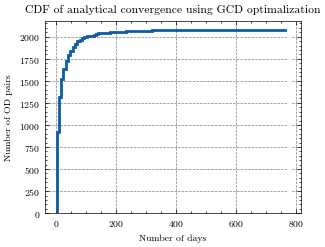

In [10]:
#cdf of the analytical convergence 
plt.figure()
# plt.hist(df["analytical"], bins=100, cumulative=True, histtype='step', label='Analytical', linewidth=2)
plt.hist(df["gcd_analytical"], bins=100, cumulative=True, histtype='step', label='GCD analytical', linewidth=2)
plt.title("CDF of analytical convergence using GCD optimalization")
plt.xlabel("Number of days")
plt.ylabel("Number of OD pairs")
last_bin = df["analytical"].max()
plt.axvline(x=last_bin, color='white', linewidth=3)
# get rid of the last tick
plt.show()


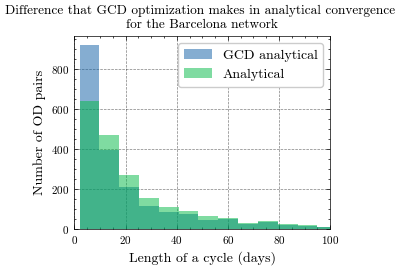

In [43]:
#distribution of the analytical convergence compared to the gcd
plt.figure()
#increase the font size of the labels
plt.rcParams.update({'font.size': 8})
#increase the font size of the axis and legend

plt.rcParams.update({'axes.labelsize': 10, 'legend.fontsize': 10, 'xtick.labelsize': 8, 'ytick.labelsize': 8})
plt.hist(df["gcd_analytical"], bins=100, alpha=0.5, label='GCD analytical',  linewidth=2)
plt.hist(df["analytical"], bins=100, alpha=0.5, label='Analytical',  linewidth=2)
plt.title("Difference that GCD optimization makes in analytical convergence \nfor the Barcelona network")
plt.xlabel("Length of a cycle (days)")
plt.ylabel("Number of OD pairs")
plt.legend()
plt.xlim(0, 100)
plt.axvline(x=last_bin, color='white', linewidth=3)
#save transparent   
plt.savefig("analytical_vs_gcd_analytical.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

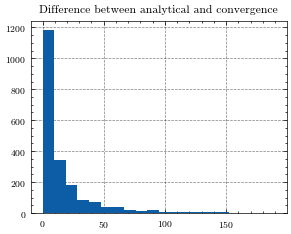

In [12]:
# plot results above as a difference histogram
conv_diff = df["analytical"] - df["convergence"]
# limit x to 200
conv_diff = conv_diff[conv_diff < 200]
plt.hist(conv_diff, bins=20)
plt.title("Difference between analytical and convergence")
plt.show()


1354
1360


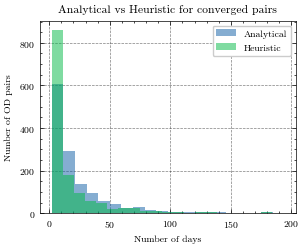

percentage of cases that are inclued in a plot above:  0.6515880654475458


In [13]:
# heuristic vs analytical approach
# histogram
dftmp = df[df["convergence"] != -1]
print(dftmp["analytical"][dftmp["analytical"] < 200].size)
print(dftmp["convergence"][dftmp["convergence"] < 200].size)
plt.figure()
plt.hist(dftmp["analytical"][dftmp["analytical"] < 200], bins=20, alpha=0.5, label="Analytical")
plt.hist(dftmp["convergence"][dftmp["convergence"] < 200], bins=20, alpha=0.5, label="Heuristic")
plt.legend(loc="upper right")
plt.title("Analytical vs Heuristic for converged pairs")
plt.xlabel("Number of days")
plt.ylabel("Number of OD pairs")
plt.show()


print("percentage of cases that are inclued in a plot above: ", dftmp["analytical"][dftmp["analytical"] < 200].size / df["analytical"].size)

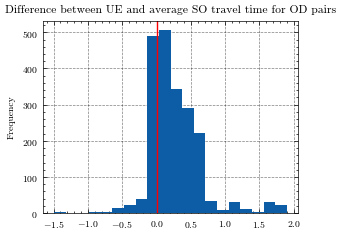

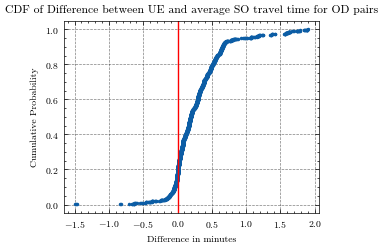

In [14]:
# create plots

# sort the df by the difference
df = df.sort_values(by="difference")

# create a histogram of the difference
plt.figure()
df["difference"].plot(kind="hist", bins=20)
# add line at 0
plt.axvline(x=0, color="red")
plt.title("Difference between UE and average SO travel time for OD pairs")
plt.show()
# mke it cdf plot

# Extract the data from the 'difference' column
sorted = df["difference"].sort_values()

# Calculate the cumulative distribution
cdf = np.arange(1, len(sorted) + 1) / len(sorted)

# Plot the CDF
plt.figure()
plt.plot(sorted, cdf, marker=".", linestyle="none")
plt.axvline(x=0, color="red")
# add units - x axis is in minutes
plt.xlabel("Difference in minutes")
plt.title("CDF of Difference between UE and average SO travel time for OD pairs")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()

In [15]:
# print percentage of negative differences
print("Percentage of OD pairs with negative differences: ", (df["difference"] < 0).sum() / len(df) * 100, "%")
print("Percentage of OD pairs with positive differences: ", (df["difference"] > 0).sum() / len(df) * 100, "%")

Percentage of OD pairs with negative differences:  17.420596727622716 %
Percentage of OD pairs with positive differences:  82.53128007699712 %


In [16]:
# print 5 pairs with the highest difference
print("5 pairs with the highest difference: ")
print(df.head(5))


5 pairs with the highest difference: 
       convergence difference    UE_time  \
99 33            2      -1.49       13.4   
91 22            5     -1.486       17.2   
92 33           25  -1.462622  13.400978   
16 98            4  -0.843319  20.254181   
   102          -1  -0.823228  20.254272   

                                                     mean  \
99 33   [14.89, 29.78, 44.67, 59.56, 74.45, 89.34, 104...   
91 22   [18.686, 37.372, 56.05799999999999, 74.744, 93...   
92 33   [14.863599999999998, 29.727200000000003, 44.59...   
16 98   [21.0975, 42.195, 63.292500000000004, 84.39, 1...   
   102  [21.0775, 42.155, 63.232499999999995, 84.31, 1...   

                                                 variance  \
99 33   [0.04839999999999989, 0.0, 0.0483999999999995,...   
91 22   [0.04646399999999952, 0.03097599999999968, 0.0...   
92 33   [0.04770303999999989, 0.02044416000000012, 0.0...   
16 98   [0.005418750000000108, 0.007225000000000145, 0...   
   102  [0.00811875000000

In [17]:
df2 = df[df["convergence"] != -1].copy()
df3 = df[df["convergence"] == -1].copy()

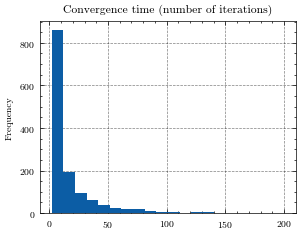

In [18]:
# lenght of the average cycle (convergence)
# filter out the pairs that did not converge
plt.figure()
df2["convergence"].plot(kind="hist", bins=20)
plt.title("Convergence time (number of iterations)")
plt.show()


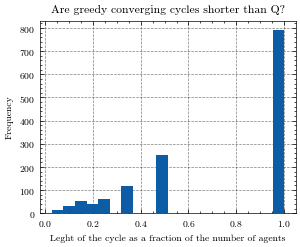

In [19]:
# convergence/agents
plt.figure()
(df2["convergence"] / df2["agents"]).plot(kind="hist", bins=20)
plt.title("Are greedy converging cycles shorter than Q?")
plt.xlabel("Leght of the cycle as a fraction of the number of agents")
plt.show()

# sort by this ratio and print head
df2["ratio"] = df2["convergence"] / df2["agents"]
df2 = df2.sort_values(by="ratio")
      

In [20]:
# check length of arrays at df['analytical_inequity_norm'] and df['analytical_inequity']
print("Length of analytical_inequity_norm: ", df['analytical_inequity_norm'].apply(len).max())
print("Length of analytical_inequity: ", df['analytical_inequity'].apply(len).max())
# cut at 200
df['analytical_inequity_norm'] = df['analytical_inequity_norm'].apply(lambda x: x[:200])
df['analytical_inequity'] = df['analytical_inequity'].apply(lambda x: x[:200])

print("Length of analytical_inequity_norm after cut: ", df['analytical_inequity_norm'].apply(len).max())
print("Length of analytical_inequity after cut: ", df['analytical_inequity'].apply(len).max())
print("Length of analytical_inequity_norm after cut: ", df['analytical_inequity_norm'].apply(len).min())
print("Length of analytical_inequity after cut: ", df['analytical_inequity'].apply(len).min())


Length of analytical_inequity_norm:  200
Length of analytical_inequity:  200
Length of analytical_inequity_norm after cut:  200
Length of analytical_inequity after cut:  200
Length of analytical_inequity_norm after cut:  200
Length of analytical_inequity after cut:  200


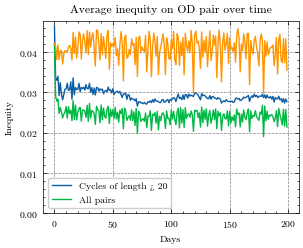

In [21]:
# plot average inequity for non-converging cycles with tolerance
avg_inequity = np.mean(df3['inequity'].to_list(), axis=0)
avg_inequity_all = np.mean(df['inequity'].to_list(), axis=0)
avg_analytical_inequity = np.mean(df['analytical_inequity'].to_list(), axis=0)
df4 = df[df["analytical"] > 20]
avg_inequity_analytical = np.mean(df4['inequity'].to_list(), axis=0)
plt.figure()
# plt.plot(avg_inequity)
plt.plot(avg_inequity_analytical)
plt.plot(avg_inequity_all)
plt.plot(avg_analytical_inequity)
plt.ylim(ymin=0)
plt.xlabel("Days")
plt.ylabel("Inequity")
plt.title("Average inequity on OD pair over time")
plt.legend(["Cycles of length > 20", "All pairs"])
plt.show()



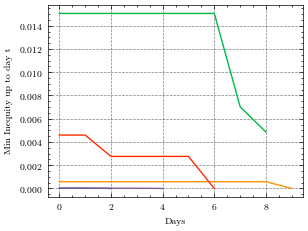

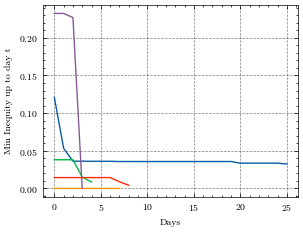

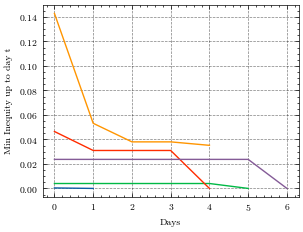

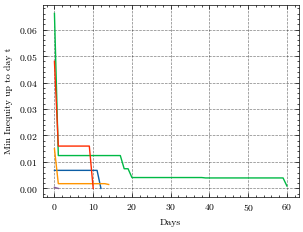

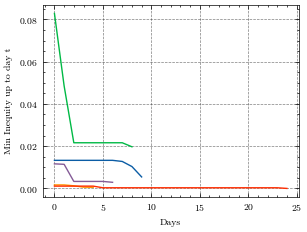

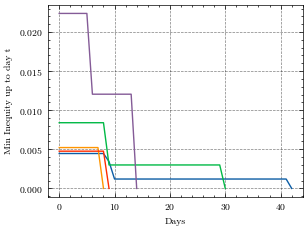

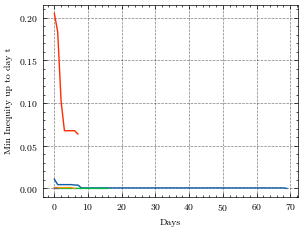

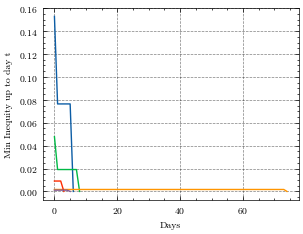

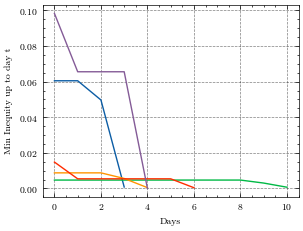

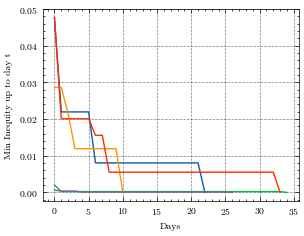

In [22]:
# pick 5 random pairs and plot their inequity
# stop plotting each pair after it reaches minimum inequity

# pick 5 random pairs
df["min_ineq_up_to_t"] = df["inequity"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])
for i in range(10):
    random_pairs = df[df["convergence"] < 100].sample(5)

    plt.figure()
    for index, row in random_pairs.iterrows():
        min_inequity = row["min_inequity"]
        
        inequity = row["min_ineq_up_to_t"]
        min_idx = np.argmin(inequity)
        inequity = inequity[:min_idx+1]
        plt.plot(inequity)
    # print(random_pairs["OD"])
    plt.xlabel("Days")
    plt.ylabel("Min Inequity up to day t")
    plt.plot()
    

In [23]:
# # plot average inequity for non-converging cycles with tolerance
# avg_inequity = np.mean(df3['inequity_norm'].to_list(), axis=0)
# avg_inequity_all = np.mean(df['inequity_norm'].to_list(), axis=0)

# plt.figure()
# plt.plot(avg_inequity)
# plt.plot(avg_inequity_all)
# plt.ylim(ymin=0)
# plt.xlabel("Days")
# plt.ylabel("Inequity")
# plt.title("Average normalized inequity on non-converging OD pairs over time")
# plt.show()

/var/folders/w4/xs9m4t1j28598sp65xft3k1h0000gn/T/ipykernel_53699/1543766928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["min_inequity_norm"] = df4["inequity_norm"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])


<Figure size 330x250 with 0 Axes>

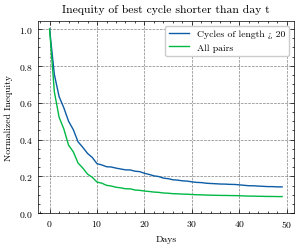

In [24]:
# for each day, calculate minimal inequity up to that day
df4["min_inequity_norm"] = df4["inequity_norm"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])

df["min_inequity_norm"] = df["inequity_norm"].apply(lambda x: [min(x[:i+1]) for i in range(len(x))])
plt.tight_layout()

plt.figure()
# plot only first 50 days
plt.plot(np.mean(df4["min_inequity_norm"].to_list(), axis=0)[:50])
plt.plot(np.mean(df["min_inequity_norm"].to_list(), axis=0)[:50])
plt.ylim(ymin=0)
plt.xlabel("Days")
plt.ylabel("Normalized Inequity")
plt.title("Inequity of best cycle shorter than day t") 
plt.legend(["Cycles of length > 20", "All pairs"])
# CHANGEEEEE (inequity of best cycle shorter than t days)
# plt.rc('font', size=20)
# make the line thicker
plt.savefig('inequity.png', format='png', dpi=600, transparent=True, bbox_inches='tight')

from matplotlib.pyplot import savefig


In [25]:
df["diff_min_inequity_10-total"] = df["min_inequity_at_10"] - df["min_inequity"]
df["diff_min_inequity_5-total"] = df["min_inequity_at_5"] - df["min_inequity"]
df["diff_min_inequity_50-total"] = df["min_inequity_at_20"] - df["min_inequity"]
df["diff_inequity_min_starting"] = df["inequity_norm"].apply(lambda x: x[0] - min(x))

print("Difference in min inequity at 10 days and total min inequity: ", df["diff_min_inequity_10-total"].mean())
print("Difference in min inequity at 5 days and total min inequity: ", df["diff_min_inequity_5-total"].mean())
for alpha in [0.5,0.2,0.1,0.01,0.001]:
    print("Alpha: ", alpha)
    print("Number of cases where min inequity at 5 days is smaller than alpha: ", (df["min_inequity_at_5"] < alpha).sum())
    print("Number of cases where min inequity at 10 days is smaller than alpha: ", (df["min_inequity_at_10"] < alpha).sum())
    print("Number of cases where min inequity at 50 days is smaller than alpha: ", (df["min_inequity_at_20"] < alpha).sum())

Difference in min inequity at 10 days and total min inequity:  0.11582040551132272
Difference in min inequity at 5 days and total min inequity:  0.2908541623847653
Alpha:  0.5
Number of cases where min inequity at 5 days is smaller than alpha:  1526
Number of cases where min inequity at 10 days is smaller than alpha:  1893
Number of cases where min inequity at 50 days is smaller than alpha:  1983
Alpha:  0.2
Number of cases where min inequity at 5 days is smaller than alpha:  770
Number of cases where min inequity at 10 days is smaller than alpha:  1205
Number of cases where min inequity at 50 days is smaller than alpha:  1551
Alpha:  0.1
Number of cases where min inequity at 5 days is smaller than alpha:  614
Number of cases where min inequity at 10 days is smaller than alpha:  925
Number of cases where min inequity at 50 days is smaller than alpha:  1224
Alpha:  0.01
Number of cases where min inequity at 5 days is smaller than alpha:  547
Number of cases where min inequity at 10 days

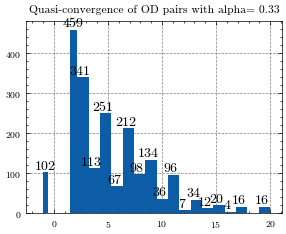

/var/folders/w4/xs9m4t1j28598sp65xft3k1h0000gn/T/ipykernel_53699/2115657430.py:23: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(cdf[:20])


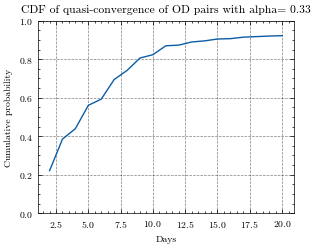

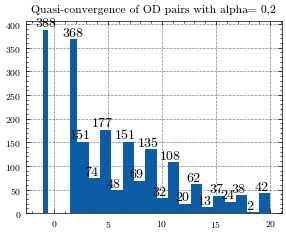

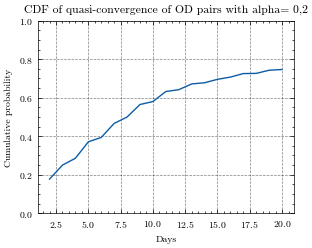

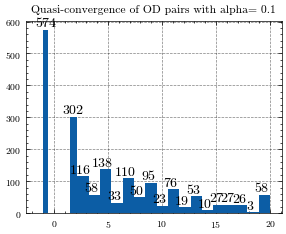

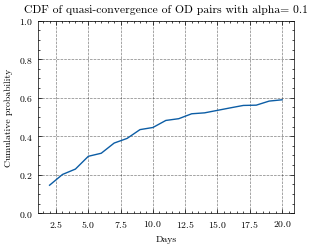

In [26]:
# analysis of almost convergence for non-converging cycles
param = ["0.33", "0,2", "0.1"]
for i in range(almost_conv_params): # for each almost convergence parameter
    # plot histogram of almost convergence
    data = df["almost_convergence_" + str(i)][df["almost_convergence_" + str(i)] <= 20]
    bin_edges = np.histogram_bin_edges(data, bins=20)
    bin_edges = np.unique(np.concatenate((bin_edges, [-1.5, -0.5, 0.5, 1.5])))
    
    plt.figure()
    plt.title("Quasi-convergence of OD pairs with alpha= " + param[i])
    counts, bins, patches = plt.hist(data, bins=bin_edges)
    for count, bin in zip(counts, bins):
        if count > 0:
            plt.text(bin + (bins[1] - bins[0]) / 2, count, str(int(count)),
                     ha='center', va='bottom', fontsize=10, color='black')
    plt.show()
    # create a cdf with the same data
    data = df["almost_convergence_" + str(i)]
    data = data.apply(lambda x: x if x  > 0 else 1e5)
    plt.figure()
    cdf = np.cumsum(data.value_counts(normalize=True).sort_index())
    #plot first 20 values
    plt.plot(cdf[:20])
    plt.xlabel("Days")
    plt.ylabel("Cumulative probability")
    plt.ylim(0,1)
    # plt.xticks(np.arange(xmin, xmax, 3))
    plt.title("CDF of quasi-convergence of OD pairs with alpha= " + param[i])
    plt.show()
    

In [27]:
# stats analysis for greedy cycles
# max, mean, median, 75th percentile, 95th percentile, std of the min inequity
print("Max min inequity: ", df["min_inequity"].max())
print("Mean min inequity: ", df["min_inequity"].mean())
print("Median min inequity: ", df["min_inequity"].median())
print("75th percentile min inequity: ", df["min_inequity"].quantile(0.75))
print("95th percentile min inequity: ", df["min_inequity"].quantile(0.95))
print("std min inequity: ", df["min_inequity"].std())

# at 5 days
print("Max min inequity at 5 days: ", df["min_inequity_at_5"].max())
print("Mean min inequity at 5 days: ", df["min_inequity_at_5"].mean())
print("Median min inequity at 5 days: ", df["min_inequity_at_5"].median())
print("75th percentile min inequity at 5 days: ", df["min_inequity_at_5"].quantile(0.75))
print("95th percentile min inequity at 5 days: ", df["min_inequity_at_5"].quantile(0.95))
print("std min inequity at 5 days: ", df["min_inequity_at_5"].std())

# at 10 days
print("Max min inequity at 10 days: ", df["min_inequity_at_10"].max())
print("Mean min inequity at 10 days: ", df["min_inequity_at_10"].mean())
print("Median min inequity at 10 days: ", df["min_inequity_at_10"].median())
print("75th percentile min inequity at 10 days: ", df["min_inequity_at_10"].quantile(0.75))
print("95th percentile min inequity at 10 days: ", df["min_inequity_at_10"].quantile(0.95))
print("std min inequity at 10 days: ", df["min_inequity_at_10"].std())

# at 20 days
print("Max min inequity at 20 days: ", df["min_inequity_at_20"].max())
print("Mean min inequity at 20 days: ", df["min_inequity_at_20"].mean())
print("Median min inequity at 20 days: ", df["min_inequity_at_20"].median())
print("75th percentile min inequity at 20 days: ", df["min_inequity_at_20"].quantile(0.75))
print("95th percentile min inequity at 20 days: ", df["min_inequity_at_20"].quantile(0.95))
print("std min inequity at 20 days: ", df["min_inequity_at_20"].std())


Max min inequity:  1.0
Mean min inequity:  0.07893064182287333
Median min inequity:  6.8908414422678e-26
75th percentile min inequity:  0.13432007553795017
95th percentile min inequity:  0.3210536448009897
std min inequity:  0.153367716835691
Max min inequity at 5 days:  1.0
Mean min inequity at 5 days:  0.3697848042076387
Median min inequity at 5 days:  0.27878061877039295
75th percentile min inequity at 5 days:  0.5000000000000001
95th percentile min inequity at 5 days:  1.0
std min inequity at 5 days:  0.35533526772037444
Max min inequity at 10 days:  1.0
Mean min inequity at 10 days:  0.19475104733419554
Median min inequity at 10 days:  0.1482526282406125
75th percentile min inequity at 10 days:  0.2745923431407302
95th percentile min inequity at 10 days:  1.0
std min inequity at 10 days:  0.24747893219054679
Max min inequity at 20 days:  1.0
Mean min inequity at 20 days:  0.12399485698388112
Median min inequity at 20 days:  0.00010756157900393723
75th percentile min inequity at 20

In [28]:
#find OD pair that has min_inequilty 1
print(df[df["min_inequity"] == 1.0])

       convergence difference    UE_time  \
92 43           -1  -0.119575   8.622021   
51 1            -1   0.058819  10.309799   
   37           -1    0.07613   5.339796   
49 36           -1    0.07669   6.930199   
51 32           -1   0.079229   7.299854   
   29           -1   0.082162   9.159809   
33 45           -1   0.147213    7.13262   
65 74           -1   0.313035  13.842135   
64 74           -1   0.356182  12.331848   
43 77           -1   0.372862   9.582148   
40 102          -1   1.352175  15.601963   
92 74           -1   1.584487  16.510187   
   23           -1   1.739569  14.390236   
   27           -1   1.845174  14.140174   
   75           -1   1.847855  16.750246   
   108          -1   1.859449  16.750218   
   109          -1   1.869386  16.750219   

                                                     mean  \
92 43   [8.74159574468085, 17.483191489361705, 26.2247...   
51 1    [10.250980392156862, 20.501960784313727, 30.75...   
   37   [5.2636666666666

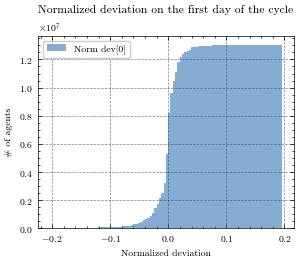

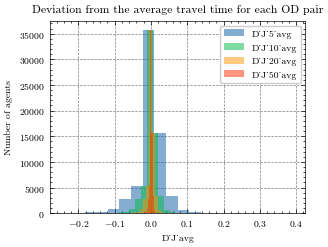

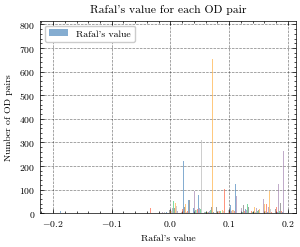

In [29]:
# wykres dla rafała

# for every agent, plot the pdf of D_J for J in [5,10,20,50]
from dijkstra_routes import calculate_routes, read_input, unify_same_time_paths


pairs_SO = []
read_input(f'./assignments/Barcelona_result_SO_OD_pairs.txt', pairs_SO)
pairs_SO = calculate_routes(pairs_SO)
pairs_SO = unify_same_time_paths(pairs_SO)
od_df = {}
rafals_plot = []
for pair in pairs_SO:
    od_str = str(pair.origin) + " -> " + str(pair.destination)
    if od_str not in df["OD"].values:
        continue
    history = df[df["OD"] == od_str]["history"]
    # print("OD pair: ", od_str)
    if history.empty:
        continue
    his = history.values[0]
    # print([route.time for route in pair.routes], int(pair.flow))
    day_0 = his[0]
    avg_time = np.mean([pair.routes[i].time for i in day_0])
    # print("Average time: ", avg_time)
    D_J = []
    # print(his, type(his))

    for day in range(len(his)):
        assignment = his[day]
        daily_deviation = np.zeros(len(assignment))
        daily_deviation_norm = np.zeros(len(assignment))
        for i, agent_route in enumerate(assignment):
            if agent_route < 0:
                continue
            route = pair.routes[agent_route]
            daily_deviation[i] = route.time - avg_time
            daily_deviation_norm[i] = (route.time - avg_time) / avg_time
            rafals_plot.append((route.time - avg_time) / avg_time)
        D_J.append(daily_deviation)
    # print("D_J: ", D_J)
    # print("D_J_5_avg: ", D_J[5]/5)
    # print("D_J_10_avg: ", D_J[10]/10)
    # print("D_J_20_avg: ", D_J[20]/20)
    # print("D_J_50_avg: ", D_J[50]/50)
    od_df[od_str] = {
        "Rafal_val": D_J[0]/avg_time,
        "D_J_5_avg": [D_J[4][i]/5 for i in range(len(D_J[4]))],
        "D_J_10_avg": [D_J[9][i]/10 for i in range(len(D_J[9]))],
        "D_J_20_avg": [D_J[19][i]/20 for i in range(len(D_J[19]))],
        "D_J_50_avg": [D_J[49][i]/50 for i in range(len(D_J[49]))],
    }

plt.figure()
plt.hist(rafals_plot, bins=100, alpha=0.5, label="Norm dev[0]", cumulative=True)
plt.xlabel("Normalized deviation")
plt.ylabel("# of agents")
plt.title("Normalized deviation on the first day of the cycle")
plt.legend()
#increase the dpi
plt.savefig('Rafal_val_cdf.png', format='png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()
# plot the D_J for each OD pair
dj_5_all = []
dj_10_all = []
dj_20_all = []
dj_50_all = []
rafals_val_all = []
for od_str, values in od_df.items():
    dj_5_all.append(values["D_J_5_avg"])
    dj_10_all.append(values["D_J_10_avg"])
    dj_20_all.append(values["D_J_20_avg"])
    dj_50_all.append(values["D_J_50_avg"])
    rafals_val_all.append(values["Rafal_val"])
#flatten the lists
dj_5_all = [item for sublist in dj_5_all for item in sublist]
dj_10_all = [item for sublist in dj_10_all for item in sublist]
dj_20_all = [item for sublist in dj_20_all for item in sublist]
dj_50_all = [item for sublist in dj_50_all for item in sublist]
plt.figure()
plt.hist(dj_5_all, bins=20, alpha=0.5, label="D_J_5_avg")
plt.hist(dj_10_all, bins=20, alpha=0.5, label="D_J_10_avg")
plt.hist(dj_20_all, bins=20, alpha=0.5, label="D_J_20_avg")
plt.hist(dj_50_all, bins=20, alpha=0.5, label="D_J_50_avg")
plt.xlabel("D_J_avg")
plt.ylabel("Number of agents")
plt.title("Deviation from the average travel time for each OD pair")
plt.legend()
#increase the dpi
plt.savefig('D_J_avg.png', format='png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()

plt.figure()
plt.hist(rafals_val_all, bins=20, alpha=0.5, label="Rafal's value", cumulative=True)
plt.xlabel("Rafal's value")
plt.ylabel("Number of OD pairs")
plt.title("Rafal's value for each OD pair")
plt.legend()
#increase the dpi
plt.savefig('Rafal_val.png', format='png', dpi=600, transparent=True, bbox_inches='tight')
plt.show()
# plot the D_J for each OD pair